In [36]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')
import pandas as pd
import math
import time
import os 
import operator
import time
import matplotlib.patches as patches


In [2]:
def test_stat(x_start,y_start,x_window,y_window,z_score):
    
    n_x,n_y=z_score.shape
    if y_start<0 or y_start+y_window>n_y or x_start<0 or x_start+x_window>n_x :        
        return 0
    
    score=np.sum(z_score[y_start:y_start+y_window,x_start:x_start+x_window])/math.sqrt(x_window*y_window)
    
    return( score)




In [185]:
window_seq_x=np.power(2,range(1,8))
window_seq_y=np.power(2,range(1,8))
n=400
cluster_x_start=200
cluster_x_end=280
cluster_y_start=200
cluster_y_end=230

len_x=cluster_x_end-cluster_x_start
len_y=cluster_y_end-cluster_y_start

area=len_x*len_y


true_box=(cluster_x_start,cluster_y_start, cluster_x_end, cluster_y_end)


In [186]:
n=400
num_obs=int(n/4)
#np.random.seed(123)
sd=10
X=np.random.randn(n,n,num_obs)#choose n/4 = # of observations per pixel.



In [187]:
cont=5
X[cluster_y_start:cluster_y_end,cluster_x_start:cluster_x_end,:]+=math.sqrt((2*math.log(n*n/area))/area)*cont
#math.sqrt((2*math.log(n*n/area))/area)*cont
#math.log(n/area)
         
         

In [188]:
z_score=np.power(np.mean(X,axis=2)/np.std(X,axis=2)*np.sqrt(num_obs),2)



In [189]:
def initial_scan(window_seq_x, window_seq_y, z_score):
    max_scan=0
    max_window=None
    start_idx=None
    end_idx=None

    result_dict={}

    for wx in window_seq_x:
        for wy in window_seq_y:
            scan_stat=np.zeros((n-wx+1,n-wy+1))
            for i in range(n-wx+1):
                for j in range(n-wy+1):
                    scan_stat[i,j]=test_stat(i,j,wx,wy,z_score)


            I_hat=np.max(scan_stat)
            cluster_idx=np.squeeze(np.where(scan_stat==I_hat))

            if max_scan<I_hat:
                max_scan=I_hat
                max_window=(wx,wy)
                start_idx=cluster_idx
                end_idx=(cluster_idx[0]+wx-1,cluster_idx[1]+wy-1)
                max_scan_stat= scan_stat   

            result_dict[str(wx),str(wy)]=(I_hat,cluster_idx, scan_stat)

        result=[max_scan, max_window, start_idx]
        
    return result, result_dict
    

In [190]:
result, result_dict=initial_scan(window_seq_x, window_seq_y, z_score)

In [191]:
result

[431.39526014571305, (64, 32), array([204, 200])]

In [192]:
max_scan=result[0]
max_window=result[1]
start_idx=result[2]


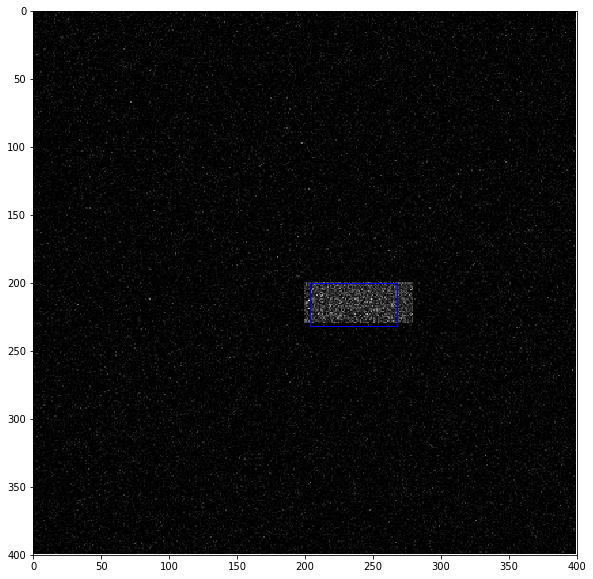

In [193]:

f,ax=plt.subplots(figsize=(10,10))
ax.set_xlim(0,400)
ax.set_ylim(0,400)
ax.invert_yaxis()
ax.imshow(z_score)
ax.add_patch(
    patches.Rectangle(
        (start_idx[0], start_idx[1]),   # (x,y)
        max_window[0],          # width
        max_window[1],          # height
        fill=False,
        color='blue'
    )
)


In [194]:
def add (start_idx,max_window,add_window_ver,add_window_hor,z_score):
    x_start=start_idx[0]
    y_start=start_idx[1]
    x_window=max_window[0]
    y_window=max_window[1]
    update_score={}
    
            
    update_score["top"]=test_stat(x_start,y_start-add_window_ver,x_window,y_window+add_window_ver,z_score)
    
    
    
    update_score['bottom']=test_stat(x_start,y_start,x_window,y_window+add_window_ver,z_score)
    update_score['left']=test_stat(x_start-add_window_hor,y_start,x_window+add_window_hor,y_window,z_score)
    update_score['right']=test_stat(x_start,y_start,x_window+add_window_hor,y_window,z_score)
            
    max_direction=max(update_score,key=update_score.get)
    score_out=update_score[max_direction]
    return  max_direction, score_out, update_score

In [195]:
def acc(start_idx, max_window, true_box):
    box1=true_box
    box2=(start_idx[0],start_idx[1], start_idx[0]+max_window[0],start_idx[1]+max_window[1])

    if box2[0] >=box1[2] or box1[0] >=box2[2] or box2[3] <= box1[1] or box1[3] <= box2[1]:
        return 0
    else:
        xi1 = max([box1[0],box2[0]])
        yi1 = max([box1[1],box2[1]])
        xi2 = min([box1[2],box2[2]])
        yi2 = min([box1[3],box2[3]])
        inter_area = (xi2-xi1)*(yi2-yi1)
        box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
        box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
        union_area = box1_area+box2_area-inter_area
        iou = inter_area*1.0/union_area
        
    return iou

In [196]:


add_window_hor=int(max_window[0]/2) 
add_window_ver=int(max_window[1]/2)

while add_window_hor>=2 or add_window_ver >=2:
    print(add_window_hor,add_window_ver)
    direct,add_scan, _ =add(start_idx, max_window, add_window_ver,add_window_hor, z_score)
    
    if add_scan<max_scan: 
        add_window_hor=int(add_window_hor/2)
        add_window_ver=int(add_window_ver/2)
        continue
    else:
        max_scan=add_scan      
        if direct=="top":
            start_idx=(start_idx[0], start_idx[1]-add_window_ver)
            max_window=(max_window[0],max_window[1]+add_window_ver)
        elif direct=="bottom":
            max_window=(max_window[0],max_window[1]+add_window_ver)
        elif direct=="left":
            start_idx=(start_idx[0]-add_window_hor,start_idx[1])
            max_window=(max_window[0]+add_window_hor, max_window[1])
        else:
            max_window=(max_window[0]+add_window_hor, max_window[1])
        
        acc_value=acc(start_idx, max_window, true_box)
        add_window_hor=int(add_window_hor/2)
        add_window_ver=int(add_window_ver/2)
        
        if add_window_hor==1:
            add_window_hor=0
            
        if add_window_ver==1:
            add_window_ver=0
    #print(acc_value)
acc_value=acc(start_idx, max_window, true_box)        
        

32 16
16 8
8 4
4 2
2 1


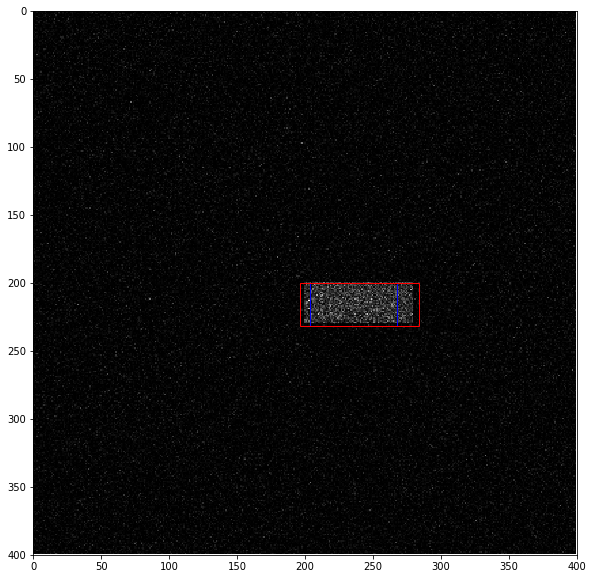

In [197]:
f,ax=plt.subplots(figsize=(10,10))
ax.set_xlim(0,400)
ax.set_ylim(0,400)
ax.invert_yaxis()
ax.imshow(z_score)


ax.add_patch(
    patches.Rectangle(
        (result[2][0], result[2][1]),   # (x,y)
        result[1][0],          # width
        result[1][1],          # height
        fill=False,
        color='blue'
    )
)

ax.add_patch(
    patches.Rectangle(
        (start_idx[0], start_idx[1]),   # (x,y)
        max_window[0],          # width
        max_window[1],          # height
        fill=False,
        color='red'
    )
)

##red :added, blue:no add



In [351]:
########simulation
window_seq_x=np.power(2,range(1,8))
window_seq_y=np.power(2,range(1,8))
n=500
num_obs=int(n/4)
size_seq=[10,15,20,25,30,35,40,45,50,55,60]
acc_tmp=list(range(10))
time_tmp=list(range(10))
accuracy=list(range(len(size_seq)))
time_spent=list(range(len(size_seq)))


for s in range(len(size_seq)):
    size=size_seq[s]
    for i in range(10):
        cluster_x_start=250
        cluster_x_end=250+size
        cluster_y_start=250
        cluster_y_end=250+size

        len_x=cluster_x_end-cluster_x_start
        len_y=cluster_y_end-cluster_y_start

        area=len_x*len_y

        true_box=(cluster_x_start,cluster_y_start, cluster_x_end, cluster_y_end)


        ###generate
        X=np.random.randn(n,n,num_obs)
        X[cluster_y_start:cluster_y_end,cluster_x_start:cluster_x_end,:]+=math.sqrt((2*math.log(n*n/area))/area)*cont
        ti=time.time()
        ##zscore
        z_score=np.power(np.mean(X,axis=2)/np.std(X,axis=2)*np.sqrt(num_obs),2)

        ##initial scan
        result, result_dict=initial_scan(window_seq_x, window_seq_y, z_score)


        #add
        max_scan=result[0]
        max_window=result[1]
        start_idx=result[2]

        add_window=int(max_window[0]/2) #assume square max window

        while add_window>=2:
            direct,add_scan, _ =add(start_idx, max_window, add_window, z_score)

            if add_scan<max_scan: 
                add_window=int(add_window/2)
                continue
            else:
                max_scan=add_scan      
                if direct=="top":
                    start_idx=(start_idx[0], start_idx[1]-add_window)
                    max_window=(max_window[0],max_window[1]+add_window)
                elif direct=="bottom":
                    max_window=(max_window[0],max_window[1]+add_window)
                elif direct=="left":
                    start_idx=(start_idx[0]-add_window,start_idx[1])
                    max_window=(max_window[0]+add_window, max_window[1])
                else:
                    max_window=(max_window[0]+add_window, max_window[1])

                acc_value=acc(start_idx, max_window, true_box)
                add_window=int(add_window/2)

        acc_value=acc(start_idx, max_window, true_box)        

        acc_tmp[i]=acc_value
        time_tmp[i]=time.time()-ti
    accuracy[s]=np.mean(acc_tmp)
    time_spent[s]=np.mean(time_tmp)
    

In [344]:
accuracy

[0.78255968169761281,
 0.7954892966360857,
 0.87890625,
 0.8212583723707626,
 0.6103515625,
 0.87890625]

Text(0,0.5,'accuracy')

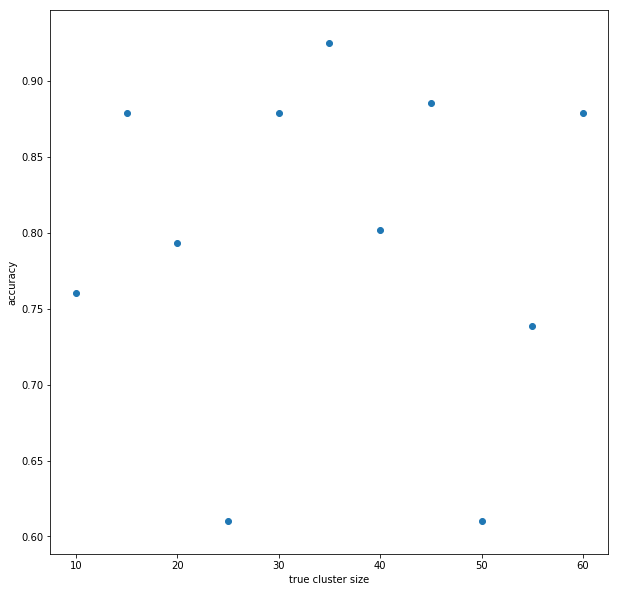

In [354]:
f,ax=plt.subplots(figsize=(10,10))
ax.scatter(size_seq,accuracy)
ax.set_xlabel("true cluster size")
ax.set_ylabel("accuracy")

Text(0,0.5,'time')

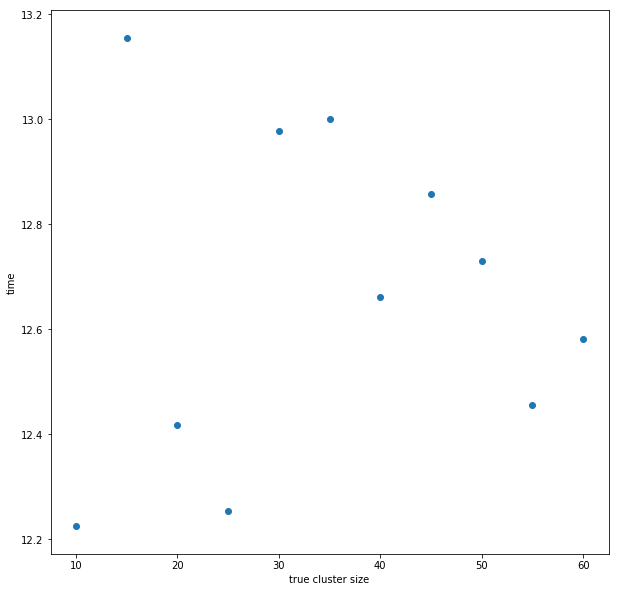

In [355]:
f,ax=plt.subplots(figsize=(10,10))
ax.scatter(size_seq,time_spent)
ax.set_xlabel("true cluster size")
ax.set_ylabel("time")